## Tarea Semanal Nro 5 | Ancho de banda de se√±ales reales

#### **Introducci√≥n y fundamentos te√≥ricos**

##### *Propuesta*

Se pide:

**1)** Realizar la estimaci√≥n de la densidad espectral de potencia (PSD) de cada se√±al mediante alguno de los m√©todos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

**2)** Realice una estimaci√≥n del ancho de banda de cada se√±al y presente los resultados en un tabla para facilitar la comparaci√≥n.

**Bonus:**

üíé Proponga alg√∫n tipo de se√±al que no haya sido analizada y repita el an√°lisis. No olvide explicar su origen y c√≥mo fue digitalizada.

##### *Un poco de teor√≠a*

En este trabajo, se realiza la estimaci√≥n de la densidad espectral de potencia (PSD, por sus siglas en ingl√©s) de varias se√±ales BOLD utilizando m√©todos cl√°sicos de estimaci√≥n espectral.

**Periodograma Ventaneado**: Este m√©todo implica aplicar una ventana sobre la se√±al antes de calcular la transformada de Fourier. El periodograma es la estimaci√≥n de la PSD sin un suavizado, y al aplicar una ventana, se mitigan algunos efectos del desparramo espectral.

**M√©todo de Welch**: Es una mejora del periodograma, que divide la se√±al en segmentos solapados, calcula la PSD para cada segmento, y luego promedia los resultados. Este enfoque reduce la varianza de la estimaci√≥n de la PSD, lo que lo convierte en un m√©todo robusto y com√∫nmente utilizado en el an√°lisis espectral.

**M√©todo Blackman-Tukey**: Este m√©todo utiliza una estimaci√≥n m√°s suave de la PSD al aplicar una autocorrelaci√≥n de la se√±al y un suavizado de la funci√≥n de autocorrelaci√≥n mediante una ventana. Esto mejora la precisi√≥n de la estimaci√≥n espectral, especialmente cuando se enfrentan a se√±ales con alta variabilidad.

Una vez obtenida la PSD de cada se√±al, se realiza una **estimaci√≥n del ancho de banda**. El ancho de banda de una se√±al se define como el rango de frecuencias en el que se concentra la mayor parte de la energ√≠a de la se√±al. En t√©rminos pr√°cticos, el ancho de banda se puede calcular como el intervalo de frecuencias donde la PSD alcanza un cierto porcentaje (por ejemplo, el 95%) de su valor m√°ximo. Este par√°metro es importante porque nos da una idea de la "anchura" de la distribuci√≥n de frecuencias de la se√±al, lo cual es √∫til para caracterizar su comportamiento din√°mico.



In [1]:

############ IMPORTAR LIBRERIAS ############
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.io as sio
import pandas as pd

In [2]:

######### DEFINICION DE FUNCIONES #########

def blackman_tukey(x, fs, M=None):
    x = x.flatten()
    N = len(x)
    if M is None:
        M = N // 5

    r_len = 2 * M - 1
    xx = x[:r_len]
    r = np.correlate(xx, xx, mode='same') / r_len
    ventana = sig.windows.blackman(r_len)
    psd = np.abs(np.fft.fft(r * ventana, n=N))
    psd = psd[:N // 2]
    freqs = np.linspace(0, fs, N, endpoint=False)[:N // 2]
    return freqs, psd


def graficar_densidad_espectral(fs, N, periodogram, ff_pm, pm, ff_welch, welch, ff_bt, bt, titulo):
    eps = 1e-12  # Para evitar log(0)

    plt.figure(figsize=(10, 6))
    plt.suptitle(f'Densidad espectral de potencia - {titulo} (en dB)')

    plt.subplot(2, 2, 1)
    plt.plot(np.linspace(0, fs, N, endpoint=False)[:N // 2], 10 * np.log10(periodogram[:N // 2] + eps))
    plt.title('Periodograma est√°ndar')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Densidad espectral [dB]')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(ff_pm, 10 * np.log10(pm + eps))
    plt.title('Periodograma ventaneado (Flattop)')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Densidad espectral [dB]')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(ff_welch, 10 * np.log10(welch + eps))
    plt.title('M√©todo de Welch')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Densidad espectral [dB]')
    plt.grid(True)
    plt.subplot(2, 2, 4)
    plt.plot(ff_bt, 10 * np.log10(bt+ eps))
    plt.title('M√©todo de Blackman-Tukey')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Densidad espectral [dB]')
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    

def get_bandwidth_to_percent(freqs, psd, H_percent):
    
    # Paso 1: calcular el √°rea total bajo la curva (integral aproximada)
    delta_f = freqs[1] - freqs[0]
    total_area = np.sum(psd * delta_f)

    # Paso 2: calcular el √°rea acumulada
    accumulated_area = 0
    target_area = total_area * (H_percent / 100)

    for i in range(len(psd)):
        accumulated_area += psd[i] * delta_f
        if accumulated_area >= target_area:
            return i, freqs[i]

    # Si no se alcanz√≥ el porcentaje, devolver el √∫ltimo bin
    return len(psd) - 1, freqs[-1]



In [3]:

######## CARGA DE DATOS ########

# Cargar la se√±al ECG
fs_ecg = 1000 # Hz
ecg = np.load('ecg_sin_ruido.npy')
ecg = ecg / np.std(ecg) # Normalizar la se√±al

# Cargar la se√±al PPG
fs_ppg = 400 # Hz
ppg = np.load('ppg_sin_ruido.npy')
ppg = ppg / np.std(ppg) # Normalizar la se√±al

# Cargar la se√±al de audio
fs_audio, audio = sio.wavfile.read('la cucaracha.wav')


#### Carga de las se√±ales

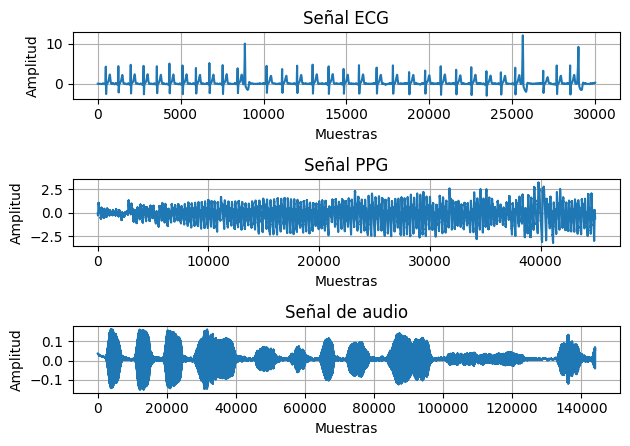

In [4]:

######## GRAFICAR SE√ëALES ########
plt.figure()

# Graficar la se√±al ECG
plt.subplot(3,1, 1)
plt.plot(ecg)
plt.title('Se√±al ECG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)

# Graficar la se√±al PPG
plt.subplot(3,1, 2)
plt.plot(ppg)
plt.title('Se√±al PPG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)

# Graficar la se√±al de audio
plt.subplot(3,1, 3)
plt.plot(audio)
plt.title('Se√±al de audio')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])



In [5]:

##### CALCULO DEL PERIODOGRAMA ESTANDAR #######

N_ecg = ecg.shape[0]
df_ecg = fs_ppg / N_ecg
ff_ecg = np.linspace(0, fs_ecg, N_ecg, endpoint=False)
fft_ecg = np.fft.fft(ecg.flatten())
pe_ecg=np.abs(fft_ecg)**2

N_ppg = ppg.shape[0]
df_ppg = fs_ppg / N_ppg
ff_ppg = np.linspace(0, fs_ppg, N_ppg, endpoint=False)
fft_ppg = np.fft.fft(ppg.flatten())
pe_ppg=np.abs(fft_ppg)**2

N_audio = audio.shape[0]
df_audio = fs_audio / N_audio
ff_audio = np.linspace(0, fs_audio, N_audio, endpoint=False)
fft_audio = np.fft.fft(audio.flatten())
pe_audio=np.abs(fft_audio)**2


#### Se verifica el teorema de parceval para cada se√±al

In [6]:


##### VERIFICAR TEOREMA DE PARESEVAL ######

suma_temp = np.sum(ecg.flatten()**2)
suma_frec = np.sum(pe_ecg) / N_ecg  
print("ECG")
print("Suma de cuadrados en el dominio del tiempo:", suma_temp)
print("Suma de cuadrados en el dominio de la frecuencia:", suma_frec)

suma_temp = np.sum(ppg.flatten()**2)
suma_frec = np.sum(pe_ppg) / N_ppg  
print("PPG")
print("Suma de cuadrados en el dominio del tiempo:", suma_temp)
print("Suma de cuadrados en el dominio de la frecuencia:", suma_frec)

suma_temp = np.sum(audio.flatten()**2)
suma_frec = np.sum(pe_audio) / N_audio 
print("AUDIO")
print("Suma de cuadrados en el dominio del tiempo:", suma_temp)
print("Suma de cuadrados en el dominio de la frecuencia:", suma_frec)


ECG
Suma de cuadrados en el dominio del tiempo: 32462.28695506214
Suma de cuadrados en el dominio de la frecuencia: 32462.286955062144
PPG
Suma de cuadrados en el dominio del tiempo: 45272.75786396239
Suma de cuadrados en el dominio de la frecuencia: 45272.75786396238
AUDIO
Suma de cuadrados en el dominio del tiempo: 272.10394
Suma de cuadrados en el dominio de la frecuencia: 272.10394


#### Se calcula la densidad espectral por diferentes m√©todos. 

Especificaciones
- Periodograma ventaneado: Se ventanea con Hlattop para mitigar el desparramo espectral
- Welch: Se ventanea con Hann
- Blackman-Tukey: Se aplica mediante la funci√≥n proporcionada por el profesor, modificada para que tambi√©n devuelva el vector de las frecuencias. Se configuro un par√°metro M=N_audio//10 para reducir la varianza en los resultados

In [7]:

##### CALCULO DEL ESPECTRO CON PERIODOGRAMA VENTANEADO #######

ff_pv_ecg, pv_ecg = sig.periodogram(ecg, fs=fs_ecg, window='flattop', nfft=N_ecg-2, detrend='constant', return_onesided=True, scaling='density', axis=-1)
ff_pv_ppg, pv_ppg = sig.periodogram(ppg, fs=fs_ppg, window='flattop', nfft=N_ppg-2, detrend='constant', return_onesided=True, scaling='density', axis=-1)
ff_pv_audio, pv_audio = sig.periodogram(audio, fs=fs_audio, window='flattop', nfft=N_audio-2, detrend='constant', return_onesided=True, scaling='density', axis=-1)

##### CALCULO DEL ESPECTRO CON WELCH #######

ff_wel_ecg, wel_ecg = sig.welch(ecg, fs=fs_ecg, window='hann', nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
ff_wel_ppg, wel_ppg = sig.welch(ppg, fs=fs_ppg, window='hann', nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
ff_wel_audio, wel_audio = sig.welch(audio, fs=fs_audio, window='hann', nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')

##### CALCULO DEL ESPECTRO CON BLACKMAN - TUKEY #######

ff_bt_ecg, bt_ecg = blackman_tukey(ecg, fs_ecg, M=N_ecg//10)
ff_bt_ppg, bt_ppg = blackman_tukey(ppg, fs_ppg, M=N_ppg//10)
ff_bt_audio, bt_audio = blackman_tukey(audio, fs_audio, M=N_audio//10)



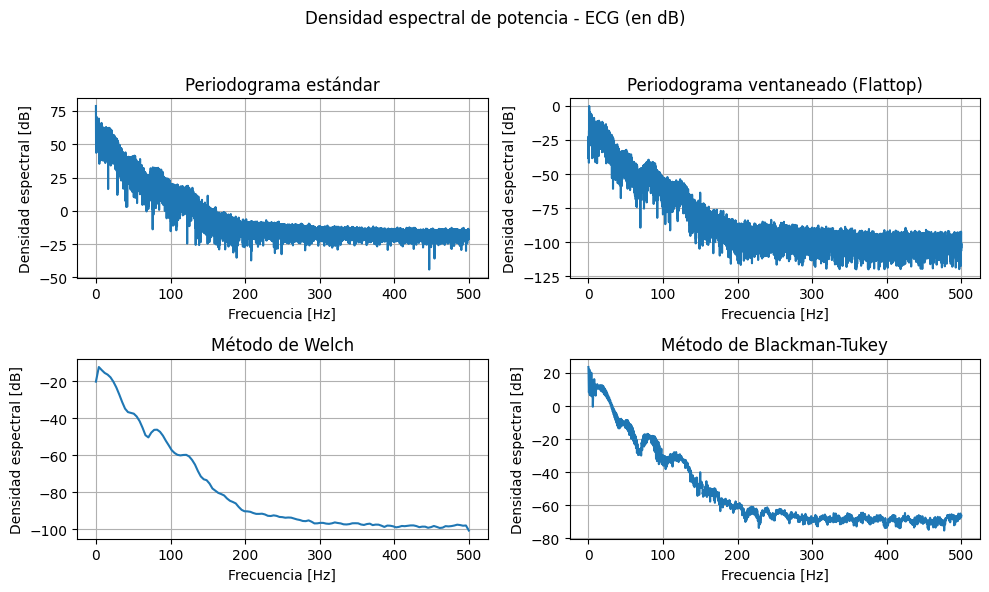

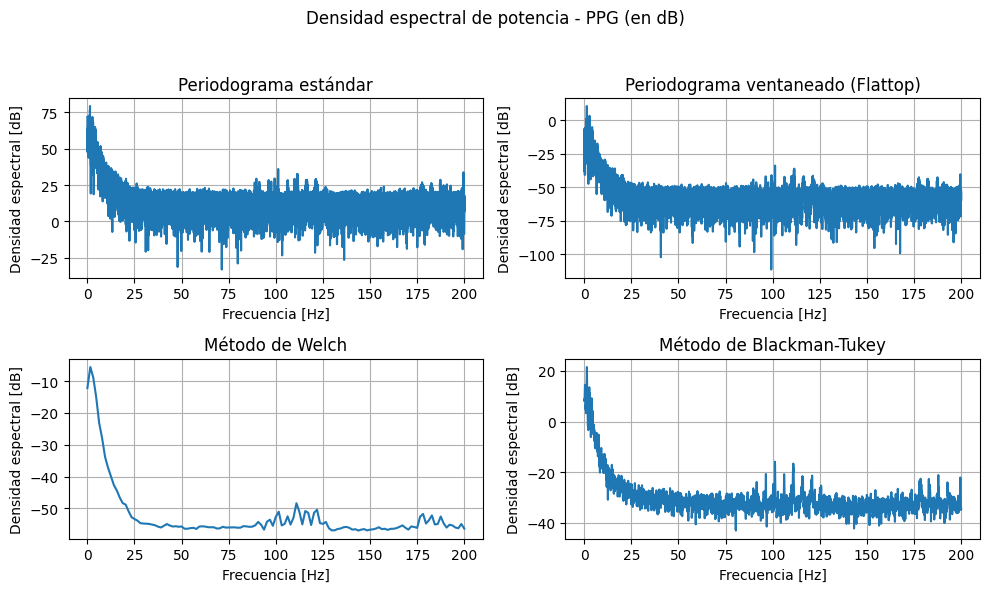

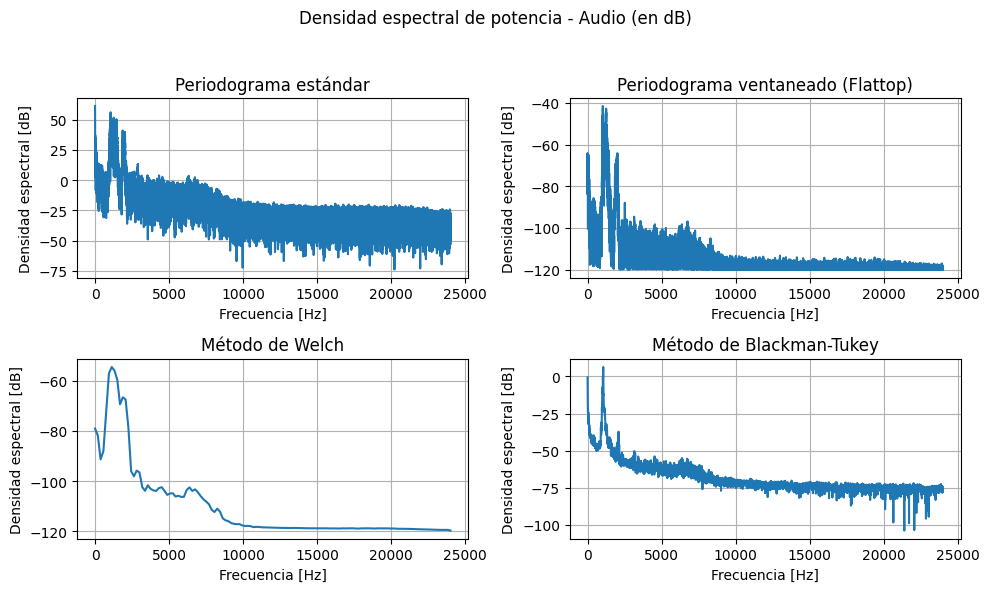

In [8]:
###### GRAFICAR EL ESPECTRO DE LA SE√ëAL PPG ######

graficar_densidad_espectral(fs_ecg, N_ecg, pe_ecg, ff_pv_ecg, pv_ecg, ff_wel_ecg, wel_ecg, ff_bt_ecg, bt_ecg, 'ECG')
graficar_densidad_espectral(fs_ppg, N_ppg, pe_ppg, ff_pv_ppg, pv_ppg, ff_wel_ppg, wel_ppg, ff_bt_ppg, bt_ppg, 'PPG')
graficar_densidad_espectral(fs_audio, N_audio, pe_audio, ff_pv_audio, pv_audio, ff_wel_audio, wel_audio, ff_bt_audio, bt_audio, 'Audio')

plt.show()


En los graficos se observa que Welch es por lejos el m√©todo de estimaci√≥n que menor varianza en la estimaci√≥n genera, luego le sigue Blackman - Tukey y luego Periodograma por ventaneo

#### C√°lculo del ancho de banda

In [9]:

######## CALCULO DEL ANCHO DE BANDA CON 95% ########

H_percent = 95  # Porcentaje deseado

idx_fe_ecg, freq_fe_ecg = get_bandwidth_to_percent(ff_ecg, pe_ecg, H_percent)
idx_fv_ecg, freq_fv_ecg = get_bandwidth_to_percent(ff_pv_ecg, pv_ecg, H_percent)
idx_wel_ecg, freq_wel_ecg = get_bandwidth_to_percent(ff_wel_ecg, wel_ecg, H_percent)
idx_bt_ecg, freq_bt_ecg = get_bandwidth_to_percent(ff_bt_ecg, bt_ecg, H_percent)

idx_fe_ppg, freq_fe_ppg = get_bandwidth_to_percent(ff_ppg, pe_ppg, H_percent)
idx_fv_ppg, freq_fv_ppg = get_bandwidth_to_percent(ff_pv_ppg, pv_ppg, H_percent)
idx_wel_ppg, freq_wel_ppg = get_bandwidth_to_percent(ff_wel_ppg, wel_ppg, H_percent)
idx_bt_ppg, freq_bt_ppg = get_bandwidth_to_percent(ff_bt_ppg, bt_ppg, H_percent)

idx_fe_audio, freq_fe_audio = get_bandwidth_to_percent(ff_audio, pe_audio, H_percent)
idx_fv_audio, freq_fv_audio = get_bandwidth_to_percent(ff_pv_audio, pv_audio, H_percent)
idx_wel_audio, freq_wel_audio = get_bandwidth_to_percent(ff_wel_audio, wel_audio, H_percent)
idx_bt_audio, freq_bt_audio = get_bandwidth_to_percent(ff_bt_audio, bt_audio, H_percent)

tabla_95 = pd.DataFrame({
    "M√©todo": ["Periodograma", "Periodograma vent.", "Welch", "Blackman-Tukey"],
    "ECG (Hz)": [freq_fe_ecg, freq_fv_ecg, freq_wel_ecg, freq_bt_ecg],
    "PPG (Hz)": [freq_fe_ppg, freq_fv_ppg, freq_wel_ppg, freq_bt_ppg],
    "Audio (Hz)": [freq_fe_audio, freq_fv_audio, freq_wel_audio, freq_bt_audio]
})

tabla_95 = tabla_95.round(2)
print("=== Ancho de banda para 95% de la energ√≠a ===")
print(tabla_95.to_string(index=False))



=== Ancho de banda para 95% de la energ√≠a ===
            M√©todo  ECG (Hz)  PPG (Hz)  Audio (Hz)
      Periodograma    998.87    399.01    46963.00
Periodograma vent.     24.37      3.95     1290.02
             Welch     23.44      4.69     1687.50
    Blackman-Tukey     24.30      3.97     1069.67


In [10]:
######## CALCULO DEL ANCHO DE BANDA CON 98% ########
H_percent = 98  # Porcentaje deseado

idx_fe_ecg, freq_fe_ecg = get_bandwidth_to_percent(ff_ecg, pe_ecg, H_percent)
idx_fv_ecg, freq_fv_ecg = get_bandwidth_to_percent(ff_pv_ecg, pv_ecg, H_percent)
idx_wel_ecg, freq_wel_ecg = get_bandwidth_to_percent(ff_wel_ecg, wel_ecg, H_percent)
idx_bt_ecg, freq_bt_ecg = get_bandwidth_to_percent(ff_bt_ecg, bt_ecg, H_percent)

idx_fe_ppg, freq_fe_ppg = get_bandwidth_to_percent(ff_ppg, pe_ppg, H_percent)
idx_fv_ppg, freq_fv_ppg = get_bandwidth_to_percent(ff_pv_ppg, pv_ppg, H_percent)
idx_wel_ppg, freq_wel_ppg = get_bandwidth_to_percent(ff_wel_ppg, wel_ppg, H_percent)
idx_bt_ppg, freq_bt_ppg = get_bandwidth_to_percent(ff_bt_ppg, bt_ppg, H_percent)

idx_fe_audio, freq_fe_audio = get_bandwidth_to_percent(ff_audio, pe_audio, H_percent)
idx_fv_audio, freq_fv_audio = get_bandwidth_to_percent(ff_pv_audio, pv_audio, H_percent)
idx_wel_audio, freq_wel_audio = get_bandwidth_to_percent(ff_wel_audio, wel_audio, H_percent)
idx_bt_audio, freq_bt_audio = get_bandwidth_to_percent(ff_bt_audio, bt_audio, H_percent)

# Tabla para 98% (despu√©s de volver a ejecutar los c√°lculos con H_percent = 98)
tabla_98 = pd.DataFrame({
    "M√©todo": ["Periodograma estandar", "Periodograma vent.", "Welch", "Blackman-Tukey"],
    "ECG (Hz)": [freq_fe_ecg, freq_fv_ecg, freq_wel_ecg, freq_bt_ecg],
    "PPG (Hz)": [freq_fe_ppg, freq_fv_ppg, freq_wel_ppg, freq_bt_ppg],
    "Audio (Hz)": [freq_fe_audio, freq_fv_audio, freq_wel_audio, freq_bt_audio]
})

tabla_98 = tabla_98.round(2)
print("\n=== Ancho de banda para 98% de la energ√≠a ===")
print(tabla_98.to_string(index=False))


=== Ancho de banda para 98% de la energ√≠a ===
               M√©todo  ECG (Hz)  PPG (Hz)  Audio (Hz)
Periodograma estandar    998.97    399.60    46974.00
   Periodograma vent.     28.74      4.26     1321.35
                Welch     31.25      4.69     2062.50
       Blackman-Tukey     28.73      4.76     1074.33


En ambos casos para 95% y 98% se observa que por comparaci√≥n, el periodograma es un p√©simo estimador y no sirve para el calculo del ancho de banda. Los otros 3 m√©todos tienen una mejor performance ya que hacen sentido entre ellos.

### **Bonus:** An√°lisis espectral de una se√±al Bold de fMRI y diferencia en el ancho de banda entre materia blanca y materia gris

Estoy haciendo Neurociencia Computacional como materia optativa y para un tp trabajamos con matrices de se√±ales Bold de fMRI. Voy a cargar una matriz en la que cada fila representa un v√≥xel y las columnas el tiempo. Cada muestra fue tomada con 3 segundos de espaciamiento. Las primeras 29100 filas corresponden a la materia gris y el resto a materia blanca 

In [11]:
Ts=3
fs_bold = 1/Ts # Hz
greylim=29100
BoldMatrix = np.load('BOLD_matrix.npy')
print("Cantidad de V√≥xeles:", BoldMatrix.shape[0])
print("Cantidad de muestras:", BoldMatrix.shape[1])

# --------------------- NORMALIZACI√ìN Z-SCORE -----------------------
mean_bolds = np.mean(BoldMatrix, axis=1, keepdims=1) # Keepdim to have 2D array as the output
std_bolds = np.std(BoldMatrix, axis=1, keepdims=1)
BoldMatrix_z = (BoldMatrix-mean_bolds)/std_bolds


Cantidad de V√≥xeles: 53738
Cantidad de muestras: 140


C:\Users\greta\AppData\Local\Temp\ipykernel_12612\398082481.py:11: RuntimeWarning: invalid value encountered in divide
  BoldMatrix_z = (BoldMatrix-mean_bolds)/std_bolds


#### Representaci√≥n de todas las se√±ales en un heatmap

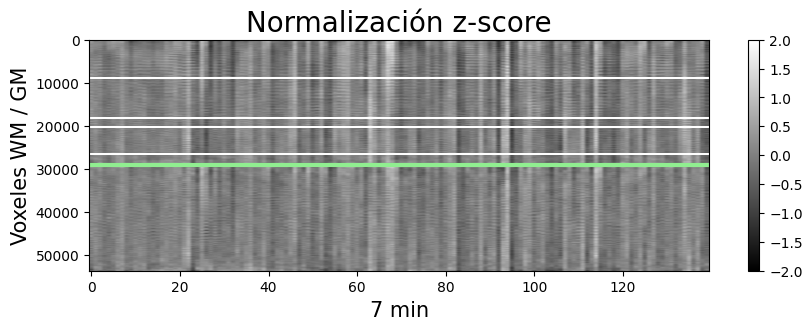

In [12]:

# -------- GR√ÅFICO --------
plt.figure(figsize=(10,3))
plt.imshow(BoldMatrix_z, cmap='gray', aspect='auto', vmin=-2, vmax=2)
plt.colorbar()
plt.title("Normalizaci√≥n z-score", fontsize=20)
plt.xlabel("7 min", fontsize=15)
plt.ylabel("Voxeles WM / GM", fontsize=15)

# L√≠nea horizontal en la cantidad de filas de nda_bold_signals_reg_gm
plt.axhline(y=greylim, color='lightgreen', linewidth=3)

#### Voy a usar el metodo de Welch para calcular la densidad espectral de potencia de cada se√±al (PSD) y luego obtener el valor del ancho de banda

In [13]:

# Procesar todas las se√±ales
bandwidths = []
for signal in BoldMatrix_z:
    freqs, psd = sig.welch(signal, fs=fs_bold, window='hann', nperseg=None, noverlap=None, scaling='density')
    _, freq_final = get_bandwidth_to_percent(freqs, psd, H_percent)
    bandwidths.append(freq_final)
    
bandwidths = np.array(bandwidths)

# Separar resultados
bandwidths_gray = bandwidths[:greylim]
bandwidths_white = bandwidths[greylim:]


c:\Users\greta\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 140, using nperseg = 140
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


#### Grafico los resultados en un histograma para comparar

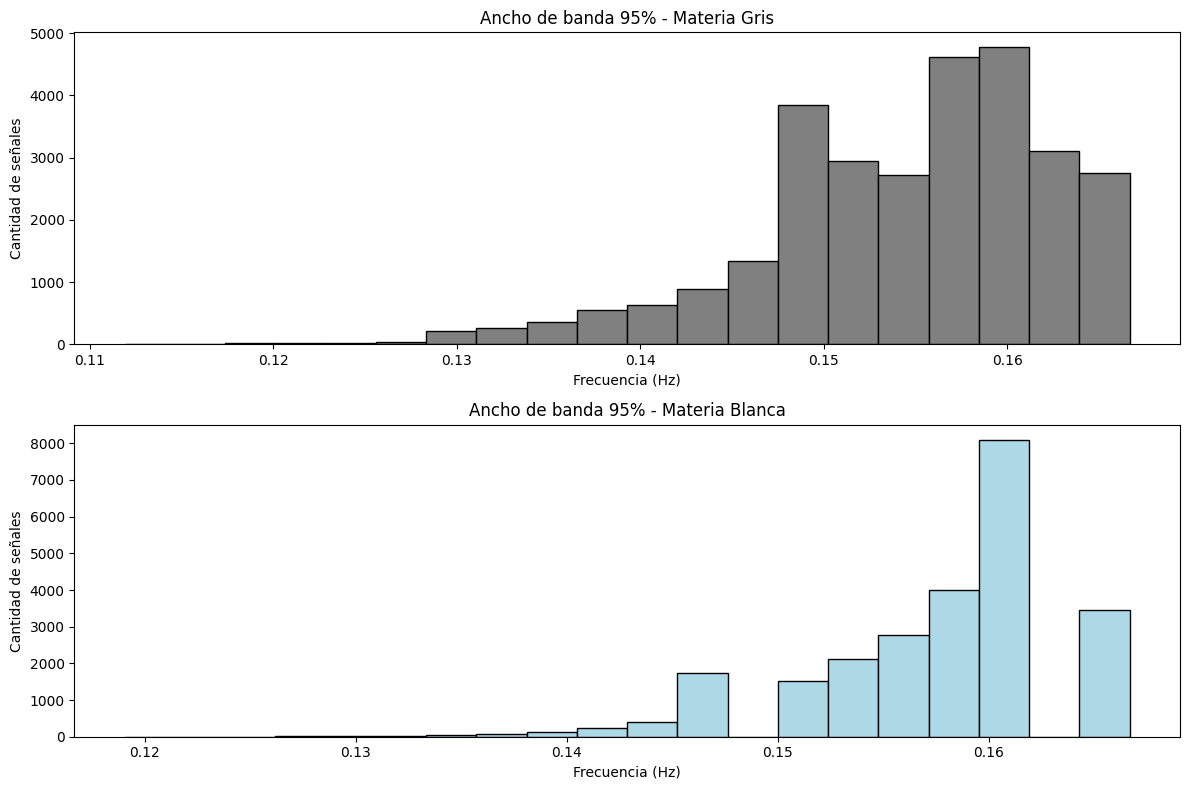

In [14]:


# Graficar histogramas
plt.figure(figsize=(12, 8))

plt.subplot(2,1, 1)
plt.hist(bandwidths_gray, bins=20, color='gray', edgecolor='black')
plt.title('Ancho de banda 95% - Materia Gris')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Cantidad de se√±ales')

plt.subplot(2,1, 2)
plt.hist(bandwidths_white, bins=20, color='lightblue', edgecolor='black')
plt.title('Ancho de banda 95% - Materia Blanca')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Cantidad de se√±ales')

plt.tight_layout()
plt.show()

#### Calculo de la media y la mediana

In [15]:

# Calcular media y mediana para la materia gris
mean_gray = np.mean(bandwidths_gray)
median_gray = np.median(bandwidths_gray)

# Calcular media y mediana para la materia blanca
mean_white = np.mean(bandwidths_white)
median_white = np.median(bandwidths_white)

# Imprimir los resultados
print(f"Media del ancho de banda para la materia gris: {mean_gray} Hz")
print(f"Mediana del ancho de banda para la materia gris: {median_gray} Hz")

print(f"Media del ancho de banda para la materia blanca: {mean_white} Hz")
print(f"Mediana del ancho de banda para la materia blanca: {median_white} Hz")

Media del ancho de banda para la materia gris: 0.15445966290296187 Hz
Mediana del ancho de banda para la materia gris: 0.15714285714285717 Hz
Media del ancho de banda para la materia blanca: 0.15680887827165932 Hz
Mediana del ancho de banda para la materia blanca: 0.15714285714285717 Hz


#### La diferencia no es representativa